In [1]:
import os
import pickle 
import traceback

import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import seaborn as sns

import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d, interp2d

import polychrom
from polychrom import polymer_analyses, contactmaps, polymerutils

import cooltools.lib.plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cooltools.lib import numutils

import sys
sys.path.append("/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments")
import simutils

/tmp/ipykernel_3789488/203338088.py:17: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
def filter_diags(hmap, ignore_diags):
    hmap_diag_filtered = np.copy(hmap)
    for i in range(ignore_diags):
        np.fill_diagonal(hmap_diag_filtered[:, i:], np.nan)  # Upper diagonals
        np.fill_diagonal(hmap_diag_filtered[i:, :], np.nan)  # Lower diagonals
    return hmap_diag_filtered

def calc_ixns(subcomps_coarsened, ooe, n_diags=[0,0]):
    if n_diags:
        trans_ooe = filter_diags(ooe, n_diags[1])
        cis_ooe = filter_diags(ooe, n_diags[0])
    else:
        trans_ooe = cis_ooe = ooe

    mean_ixns = np.nan*np.ones((4,4))
    for i in range(3):
        for j in range(3):
            mean_ixns[i][j] = np.nanmean(trans_ooe[subcomps_coarsened==i].T[subcomps_coarsened==j])
    #mean_ixns[0:2, 3] = mean_ixns[0:2, 2]
    #mean_ixns[3, 0:2] = mean_ixns[2, 0:2]

    x_loc = subcomps_coarsened == 2

    XX_inter_mask = np.zeros((ooe.shape[0], ooe.shape[0]))
    XX_intra_mask = np.zeros((ooe.shape[0], ooe.shape[0]))
    for i in np.where(x_loc)[0]:
        for j in np.where(x_loc)[0]:
            XX_inter_mask[i,j] = (np.sum(x_loc[i:j]) < j-i)
            XX_intra_mask[i,j] = (np.sum(x_loc[i:j]) == j-i)
    XX_inter_mask = XX_inter_mask.astype(bool)
    XX_intra_mask = XX_intra_mask.astype(bool)

    mean_inter_X = np.nanmean(np.ma.array(trans_ooe, mask=~XX_inter_mask).compressed())    
    mean_intra_X = np.nanmean(np.ma.array(cis_ooe, mask=~XX_intra_mask).compressed())
    
    mean_ixns[2,2] = mean_inter_X
    mean_ixns[3,3] = mean_intra_X
    
    return mean_ixns

def make_ixn_df(sim_group_path, mtx_fh, AB_self_attr, XX=0):
    aa_list = []
    ab_list = []
    bb_list = []
    ax_list = []
    bx_list = []
    xx_intra_list = []
    xx_inter_list = []
    

    for AB in AB_self_attr:
        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim_dir = 'Xboundaries'
        hmap_path = f'{sim_group_path}/{comp_dir}/{sim_dir}/results/heatmaps'
        if os.path.exists(f'{hmap_path}/{mtx_fh}'):
            with open(f'{hmap_path}/{mtx_fh}', 'rb') as o:
                mean_ixns = np.load(o)
            aa_list.append(mean_ixns[0,0])
            ab_list.append(mean_ixns[0,1])
            bb_list.append(mean_ixns[1,1])
            ax_list.append(mean_ixns[0,2])
            bx_list.append(mean_ixns[1,2])
            xx_inter_list.append(mean_ixns[2,2])
            xx_intra_list.append(mean_ixns[3,3])
        else:
            aa_list.append(np.nan)
            ab_list.append(np.nan)
            bb_list.append(np.nan)
            ax_list.append(np.nan)
            bx_list.append(np.nan)
            xx_inter_list.append(np.nan)
            xx_intra_list.append(np.nan)


    ixn_df = pd.DataFrame({
        "AA": aa_list,
        "AB": ab_list,
        "BB": bb_list,
        "AS": ax_list,
        "BS": bx_list,
        "SS_inter": xx_inter_list,
        "SS_intra": xx_intra_list,
    })
    #ixn_df['index'] = ixn_df.index
    ixn_df['AA_attr'] = AB_self_attr
    ixn_df['BB_attr'] = AB_self_attr
    ixn_df['SS_attr'] = XX
    
    return ixn_df

In [3]:
cutoff_rad = 5 
binSize = 5
base_path = f'/net/levsha/share/emily/notebooks/sims/bombyx/toy_models'

sim_dir = 'Xboundaries'

In [4]:
# load compartment labels
with open('../../polymer_info.pkl', 'rb') as f:
    monInfo = pickle.load(f)
    
chroms = monInfo['chroms']
L = monInfo['L']
n_per_chain = monInfo['L']//binSize
n_chains = 30
n_chains_per_sphere = 10

mon_id_tmp = monInfo['compartment_ID']
mon_id = np.array([mon_id_tmp[i] for i in range(0, L, binSize)])

AB_self_attr = [0.0125, 0.025,  0.0375, 0.05, 0.0625, 0.075, 0.0875, 0.1, 0.125, 0.15, 0.17, 0.25] #0.2, 
XX = 0.00

lambda_ = 100
d_X = 50
dAB_list = [5000, 1000, 400, 200, 100, 50]

In [5]:
chroms

5

In [6]:
# zoomify all of the matrices
for d_AB in dAB_list:
    d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
    for AB in AB_self_attr:
        
        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim = f'{comp_dir}__{sim_dir}'   
        hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
        sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
        if os.path.exists(f'{sim_path}/results/heatmaps/{hmap_fh}'):
            continue
        else:
            hmap_fh_unbinned = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-1_IC_chainMap.npy'
            
            try:
                mat = np.load(f'{sim_path}/results/heatmaps/{hmap_fh_unbinned}')
            except FileNotFoundError:
                print(f'{sim_path}/results/heatmaps/{hmap_fh_unbinned}')
                continue
            
            mat = mat/np.mean(np.diag(mat,k=1))
            mat_binned = numutils.zoom_array(mat, (L/binSize,L/binSize))

            save_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
            with open(f'{sim_path}/results/heatmaps/{save_fh}', 'wb') as f:
                np.save(f, mat_binned)

/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-5000/AA0.01_BB0.01_XX0.00/Xboundaries/results/heatmaps/AA0.01_BB0.01_XX0.00__Xboundaries__cutoff-05.0_binSize-1_IC_chainMap.npy
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-5000/AA0.06_BB0.06_XX0.00/Xboundaries/results/heatmaps/AA0.06_BB0.06_XX0.00__Xboundaries__cutoff-05.0_binSize-1_IC_chainMap.npy
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-5000/AA0.07_BB0.07_XX0.00/Xboundaries/results/heatmaps/AA0.07_BB0.07_XX0.00__Xboundaries__cutoff-05.0_binSize-1_IC_chainMap.npy
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-5000/AA0.09_BB0.09_XX0.00/Xboundaries/results/heatmaps/AA0.09_BB0.09_XX0.00__Xboundaries__cutoff-05.0_bi

In [7]:
for d_AB in dAB_list:
    d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
    
    Ps_sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/'+\
                    f'{d_dir}/AA{0:.2f}_BB{0:.2f}_XX{0:.2f}/{sim_dir}'
    Ps_fh = f'AA{0:.2f}_BB{0:.2f}_XX{0:.2f}__{sim_dir}__cutoff{cutoff_rad:04.1f}.txt'
    try:
        Ps = pd.read_csv(f'{Ps_sim_path}/results/Ps_scaling/{Ps_fh}', sep='\t')
        print(f'P(s) found at {Ps_sim_path}')
    except FileNotFoundError:
        print(f'No P(s) found at {Ps_sim_path}/results/Ps_scaling/{Ps_fh}')
        continue
    
    x, y = simutils.interpolate_Ps(Ps['dist'].values, Ps['Ps'].values, L)
    y = y/chroms
    y = y/y[1]
    exp_2bin = numutils.LazyToeplitz(y)
    exp = numutils.zoom_array(exp_2bin[:,:], (n_per_chain,n_per_chain))
        
    for AB in AB_self_attr:
        
        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim = f'{comp_dir}__{sim_dir}'    
        
        
        ooe_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_OOE_chainMap.npy'
        
        sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
        if os.path.exists(f'{sim_path}/results/heatmaps/{ooe_fh}'):
            continue
        else:
            hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
            try:
                mat = np.load(f'{sim_path}/results/heatmaps/{hmap_fh}')
            except FileNotFoundError:
                print(hmap_fh)
                continue
            mat = mat/np.mean(np.diag(mat,k=1))

            ooe = mat/exp[:,:]
            
            with open(f'{sim_path}/results/heatmaps/{ooe_fh}', 'wb') as f:
                np.save(f, ooe)

P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-5000/AA0.00_BB0.00_XX0.00/Xboundaries
AA0.01_BB0.01_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
AA0.06_BB0.06_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
AA0.07_BB0.07_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
AA0.09_BB0.09_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
AA0.12_BB0.12_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))


P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-1000/AA0.00_BB0.00_XX0.00/Xboundaries


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))


AA0.09_BB0.09_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
AA0.17_BB0.17_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-400/AA0.00_BB0.00_XX0.00/Xboundaries
P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-200/AA0.00_BB0.00_XX0.00/Xboundaries


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: d

AA0.09_BB0.09_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
AA0.17_BB0.17_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-100/AA0.00_BB0.00_XX0.00/Xboundaries
AA0.09_BB0.09_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy
P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-50/AA0.00_BB0.00_XX0.00/Xboundaries


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: d

AA0.09_BB0.09_XX0.00__Xboundaries__cutoff-05.0_binSize-5_IC_chainMap.npy


In [8]:
mask = np.arange(n_per_chain)
mask = mask[None, :] - mask[:, None]

In [9]:
landscape = ['B','A','X','A','B','A','X','A','B']
colors = {'A':'#ed6c56','B':'#4cafa5','X':'#a564b9'}

/tmp/ipykernel_3789488/2154300545.py:41: RuntimeWarning: invalid value encountered in divide
  hmap_img = ax.imshow(ma.masked_array(np.log10(mat/np.nanmean(mat)), mask=mask<0), cmap='fall', interpolation='none',
/tmp/ipykernel_3789488/2154300545.py:44: RuntimeWarning: divide by zero encountered in log2
  ooe_img = ax.imshow(ma.masked_array(np.log2(ooe), mask=mask>=0), cmap='coolwarm',


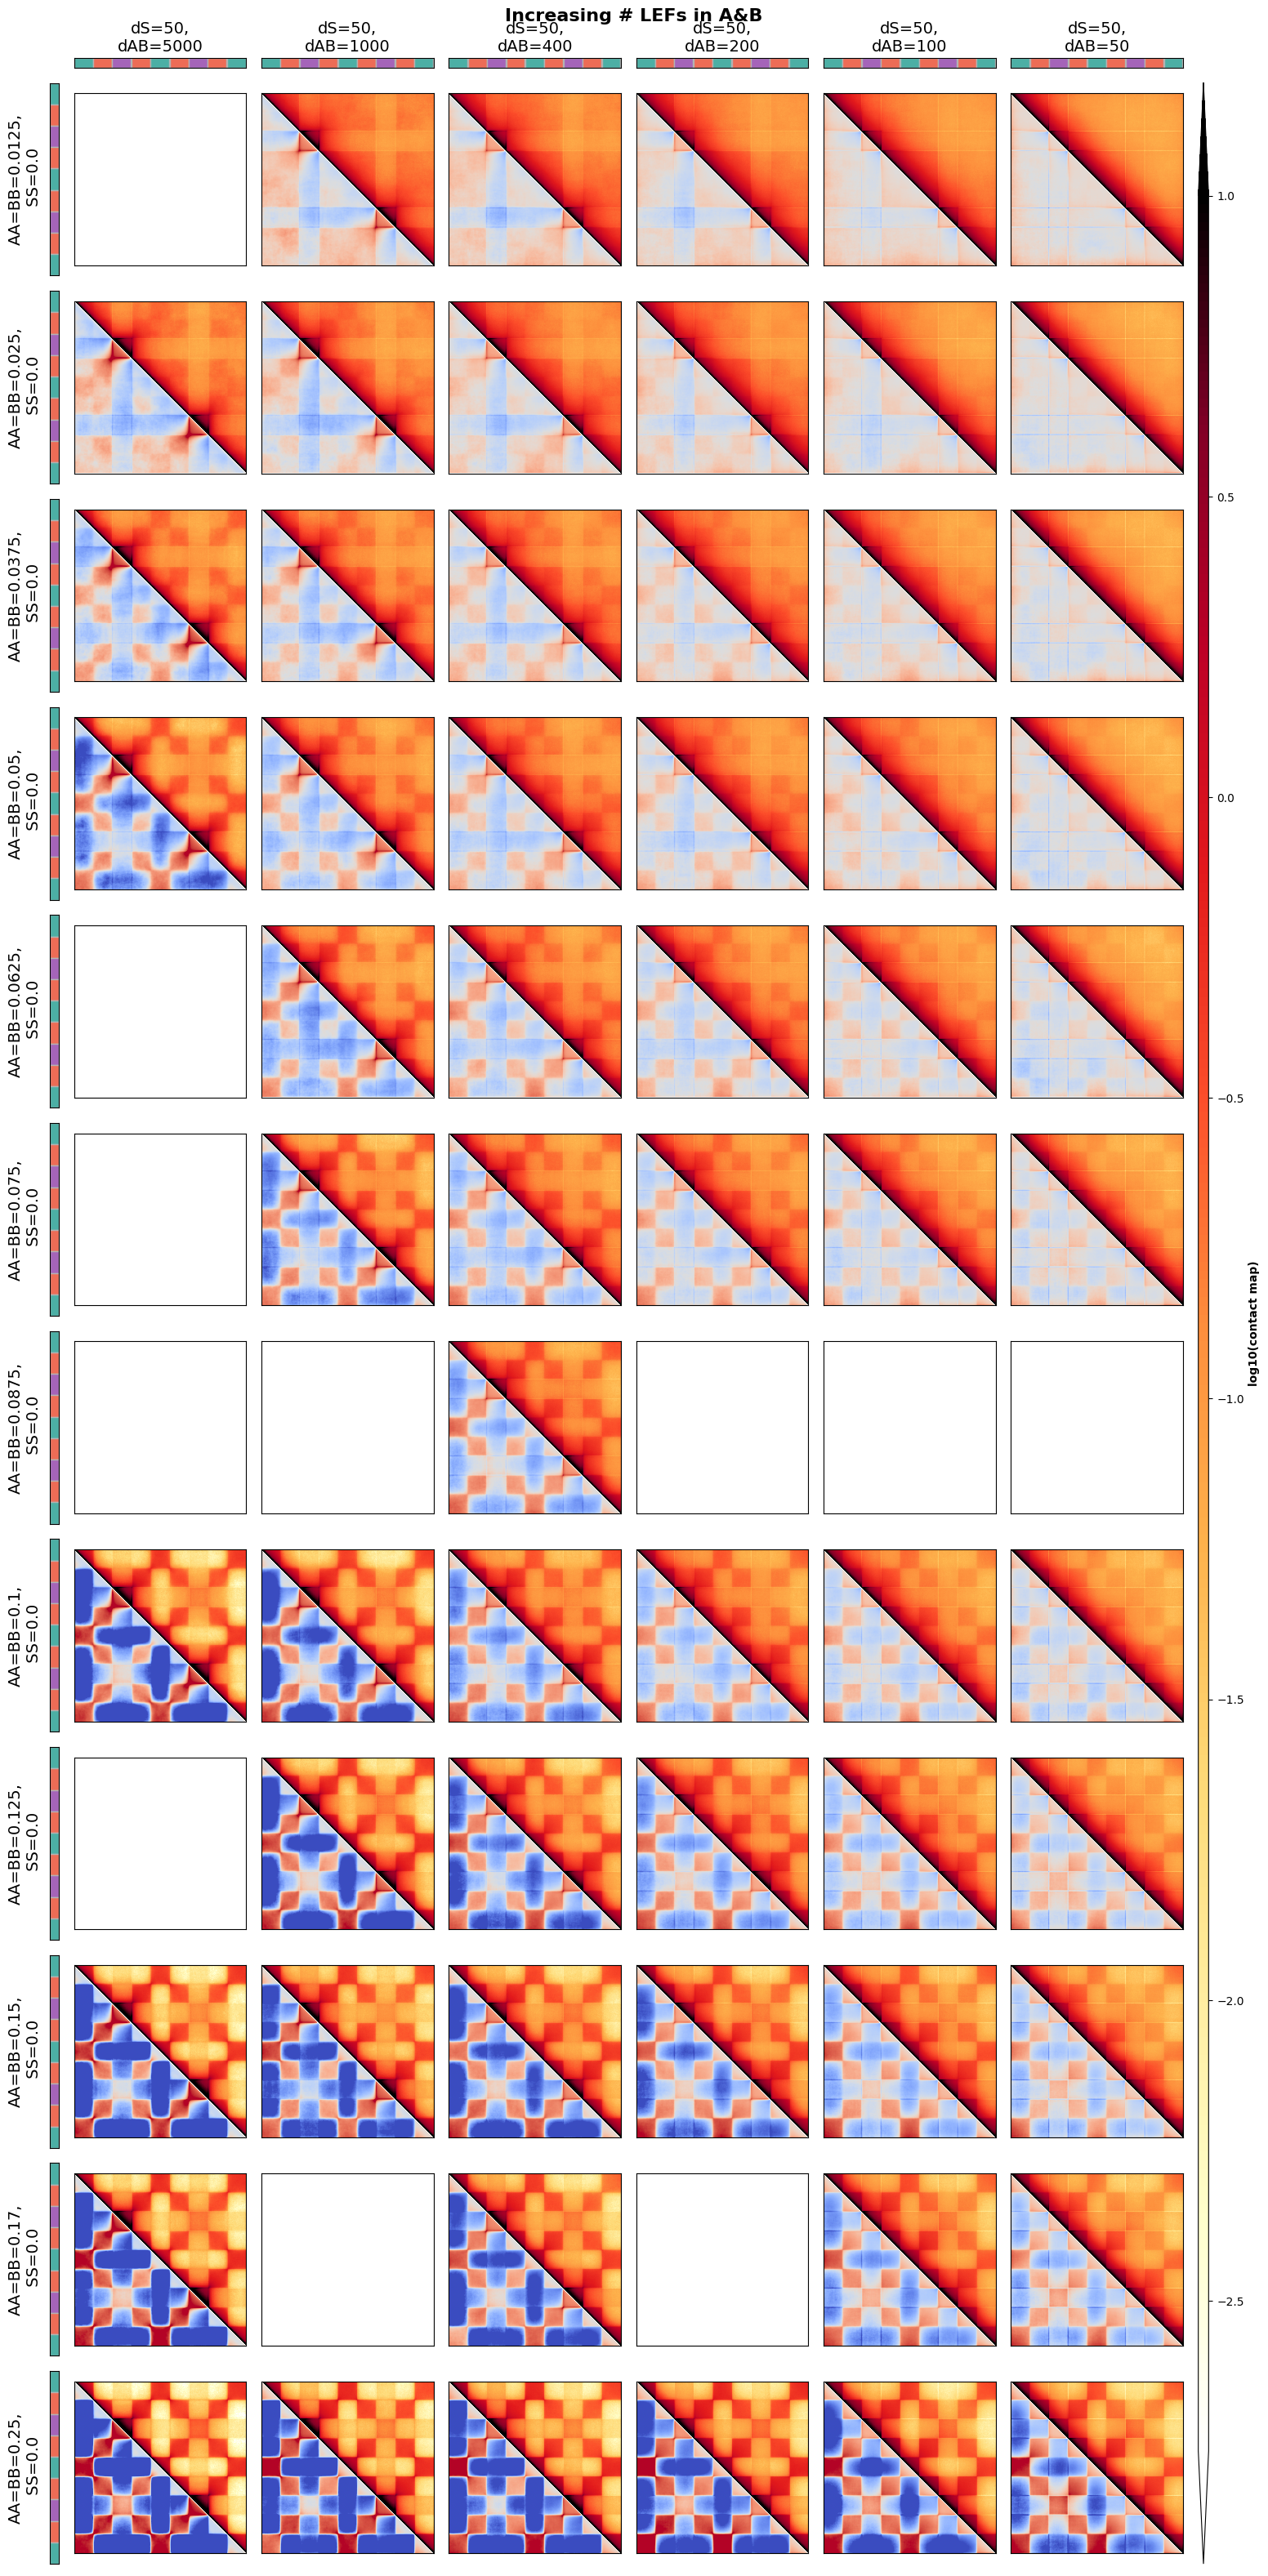

In [10]:
n_col = len(dAB_list)
n_row = len(AB_self_attr)

fig = plt.figure(figsize=(n_col*2.6, n_row*2.65))
gs = GridSpec(nrows=1+n_row, ncols=1+n_col+1,
              height_ratios=[5]+[100]*n_row,
              width_ratios=[5]+[100]*n_col+[6]
             )

for c, d_AB in enumerate(dAB_list):
    for r, AB in enumerate(AB_self_attr):
        d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim = f'{comp_dir}__{sim_dir}'    
        
        hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
        ooe_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_OOE_chainMap.npy'

        sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
        sim = f'{comp_dir}__{sim_dir}'    
        hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
        
        try:
            mat = np.load(f'{sim_path}/results/heatmaps/{hmap_fh}')
        except FileNotFoundError:
            #print(f'{sim_path}/results/heatmaps/{hmap_fh}')
            mat = np.zeros((n_per_chain, n_per_chain))
            
        try:
            ooe = np.load(f'{sim_path}/results/heatmaps/{ooe_fh}')
        except FileNotFoundError:
            #print(f'{sim_path}/results/heatmaps/{hmap_fh}')
            ooe = np.zeros((n_per_chain, n_per_chain))
        ax = fig.add_subplot(gs[r+1, c+1])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([0, mat.shape[0]])
        ax.set_ylim([mat.shape[0], 0])
        
        hmap_img = ax.imshow(ma.masked_array(np.log10(mat/np.nanmean(mat)), mask=mask<0), cmap='fall', interpolation='none',
                    vmin=-2.75, vmax=1,
                   )
        ooe_img = ax.imshow(ma.masked_array(np.log2(ooe), mask=mask>=0), cmap='coolwarm', 
                        vmin=-2, vmax=2,
                   )
        if not r:
            tax = fig.add_subplot(gs[0, c + 1], sharex=ax)
            #tax.set_title(f'AA=BB={AB}, SS={XX}', fontsize=14)#, fontweight='bold')
            xlab = ",\n".join(d_dir.split("_")[1:]).replace("X", "S").replace("-", "=")
            tax.set_title(xlab, fontsize=14)#, fontweight='bold')


            for i in range(len(landscape)):
                tax.set_xticks([])
                tax.set_yticks([])
                tax.add_patch(Rectangle(xy=(i*400/binSize, 0), width=(-5+400-3)/binSize,
                          height=1, facecolor=colors[landscape[i]], edgecolor='0.7'))
        if not c:
            lax = fig.add_subplot(gs[r+1,0], sharey=ax)
            #ylab = ", ".join(d_dir.split("_")[1:]).replace("X", "S").replace("-", "=")
            #lax.set_ylabel(ylab, fontsize=14)#, fontweight='bold')
            lax.set_ylabel(f'AA=BB={AB},\n SS={XX}', fontsize=14)

            for i in range(len(landscape)):
                lax.set_xticks([])
                lax.set_yticks([])
                lax.add_patch(Rectangle(xy=(0,i*400/binSize), width=1,
                          height=400/binSize, facecolor=colors[landscape[i]], edgecolor='0.7'))

hmap_cax = fig.add_subplot(gs[1:n_row+1,-1])
plt.colorbar(hmap_img, hmap_cax, extend='both')
hmap_cax.yaxis.set_label_position("right")
hmap_cax.set_ylabel('log10(contact map)', fontweight='bold')
fig.suptitle(f'Increasing # LEFs in A&B', fontsize=16, fontweight='bold', y=.99)

fig.tight_layout(pad=1)


/tmp/ipykernel_3789488/1105866598.py:44: RuntimeWarning: invalid value encountered in divide
  hmap_img = ax.imshow(ma.masked_array(np.log10(mat/np.nanmean(mat)), mask=mask<0), cmap='fall', interpolation='none',
/tmp/ipykernel_3789488/1105866598.py:47: RuntimeWarning: divide by zero encountered in log2
  ooe_img = ax.imshow(ma.masked_array(np.log2(ooe), mask=mask>=0), cmap='coolwarm',


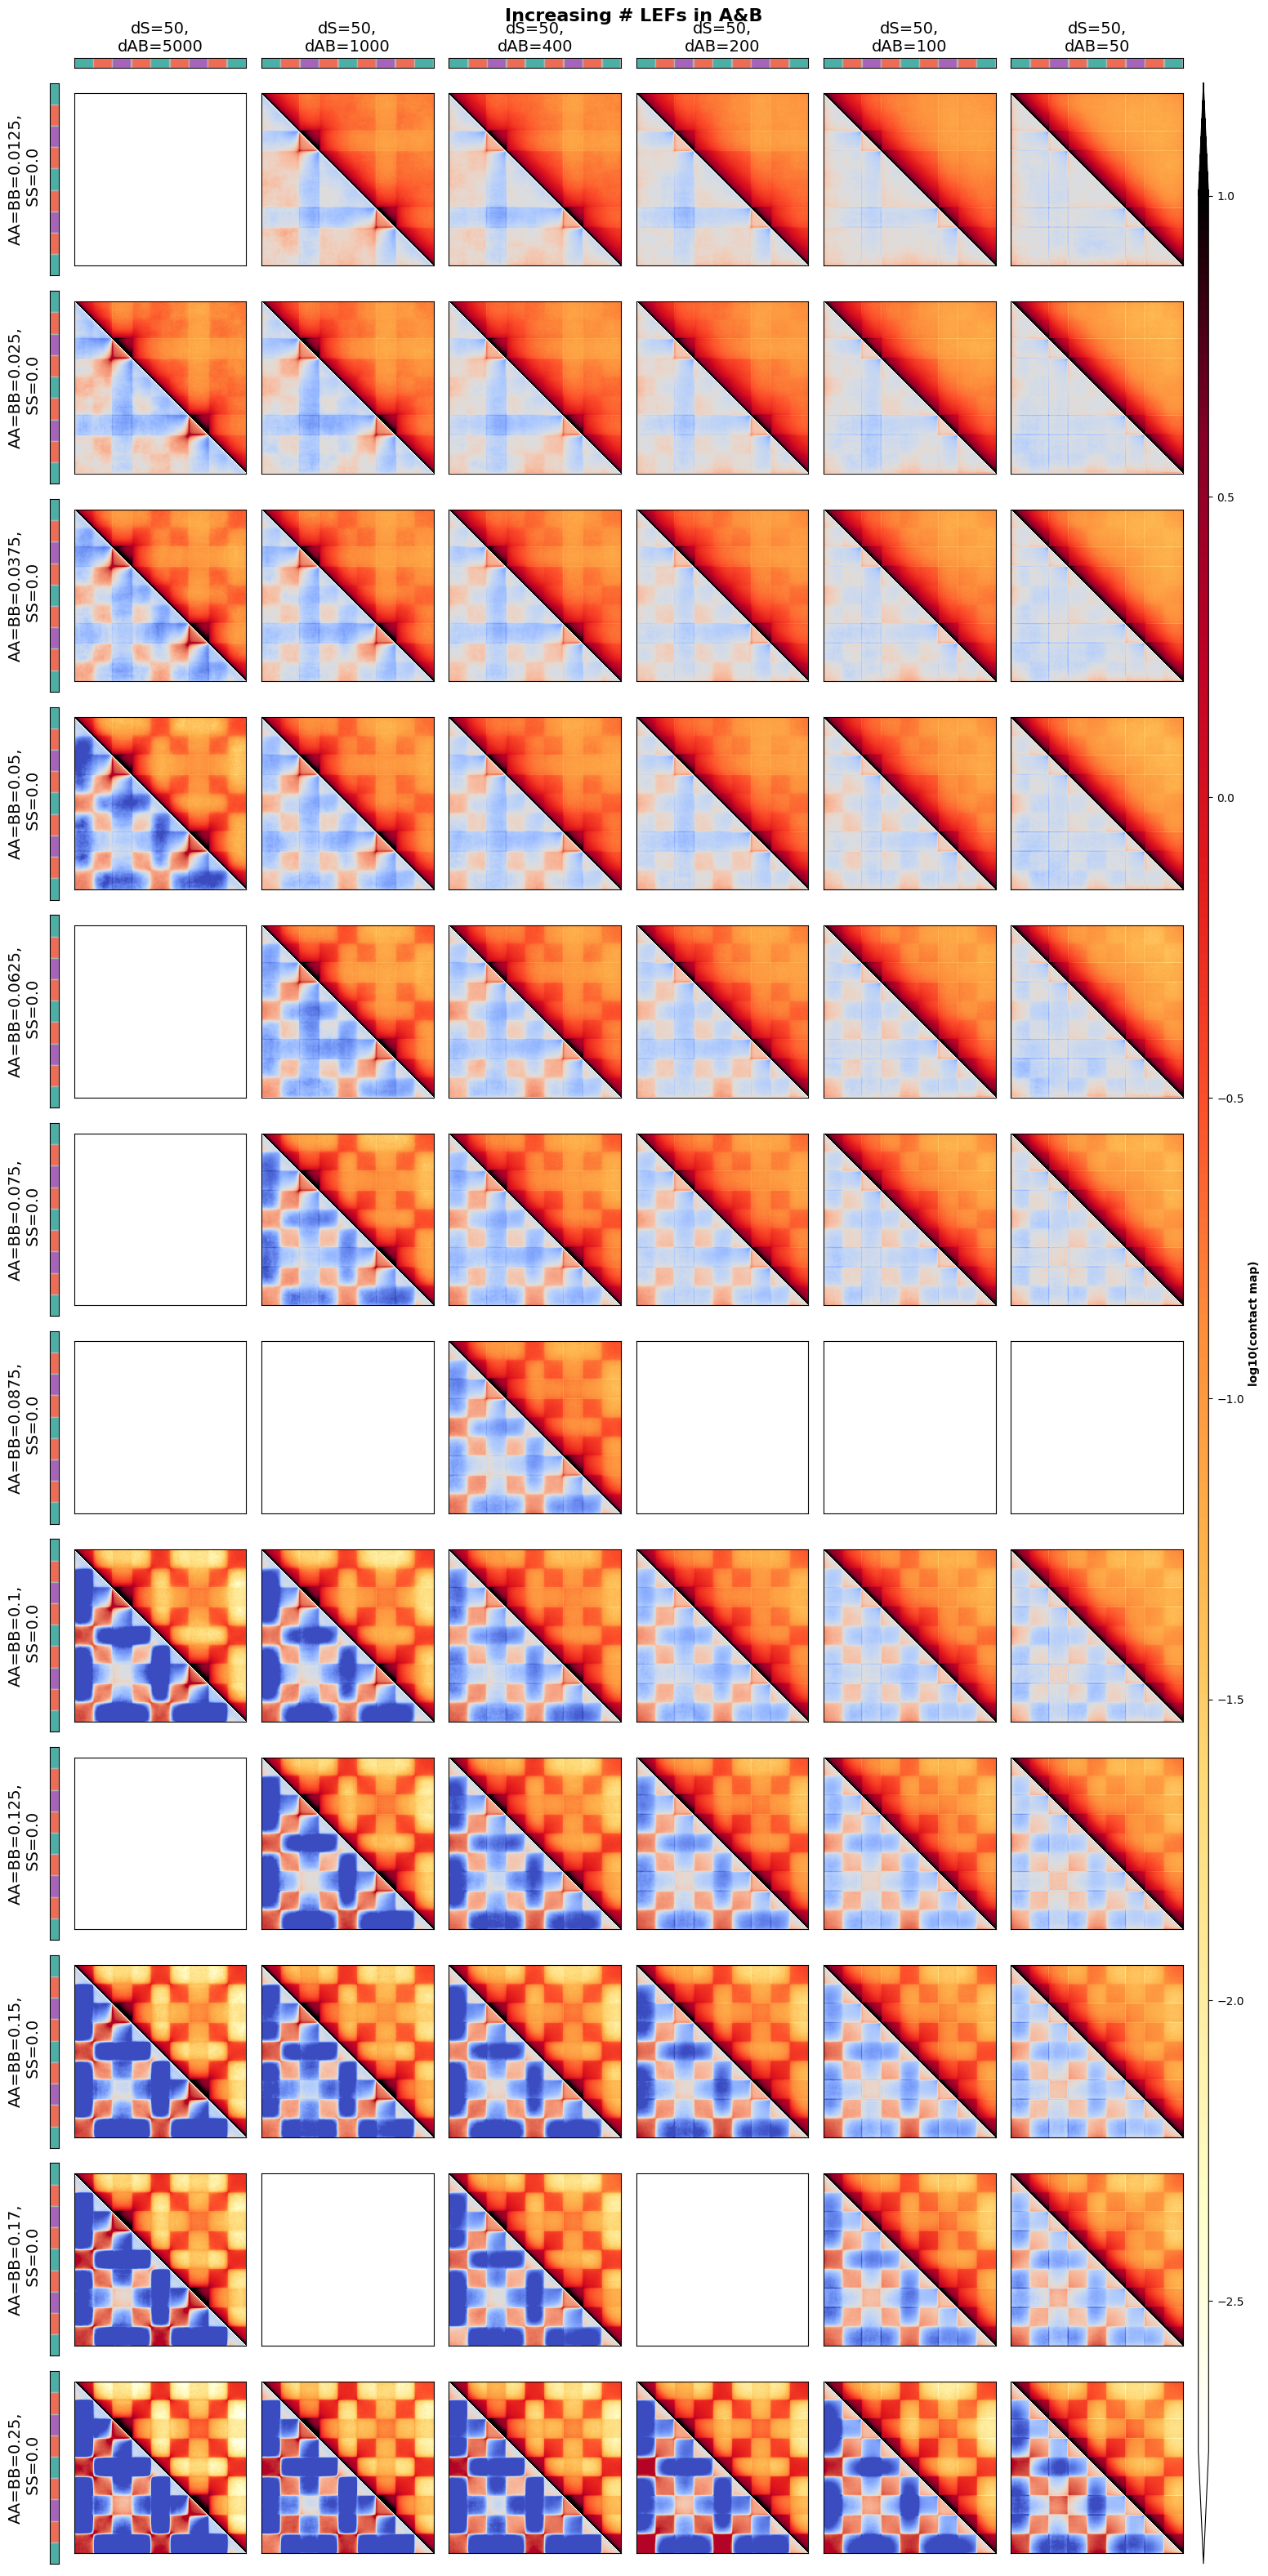

In [11]:
landscape = ['B','A','X','A','B','A','X','A','B']
colors = {'A':'#ed6c56','B':'#4cafa5','X':'#a564b9'}

n_col = len(dAB_list)
n_row = len(AB_self_attr)

fig = plt.figure(figsize=(n_col*2.6, n_row*2.65))
gs = GridSpec(nrows=1+n_row, ncols=1+n_col+1,
              height_ratios=[5]+[100]*n_row,
              width_ratios=[5]+[100]*n_col+[6]
             )

for c, d_AB in enumerate(dAB_list):
    for r, AB in enumerate(AB_self_attr):
        d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim = f'{comp_dir}__{sim_dir}'    
        
        hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
        ooe_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_OOE_chainMap.npy'

        sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
        sim = f'{comp_dir}__{sim_dir}'    
        hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
        
        try:
            mat = np.load(f'{sim_path}/results/heatmaps/{hmap_fh}')
        except FileNotFoundError:
            #print(f'{sim_path}/results/heatmaps/{hmap_fh}')
            mat = np.zeros((n_per_chain, n_per_chain))
            
        try:
            ooe = np.load(f'{sim_path}/results/heatmaps/{ooe_fh}')
        except FileNotFoundError:
            #print(f'{sim_path}/results/heatmaps/{hmap_fh}')
            ooe = np.zeros((n_per_chain, n_per_chain))
        ax = fig.add_subplot(gs[r+1, c+1])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([0, mat.shape[0]])
        ax.set_ylim([mat.shape[0], 0])
        
        hmap_img = ax.imshow(ma.masked_array(np.log10(mat/np.nanmean(mat)), mask=mask<0), cmap='fall', interpolation='none',
                    vmin=-2.75, vmax=1,
                   )
        ooe_img = ax.imshow(ma.masked_array(np.log2(ooe), mask=mask>=0), cmap='coolwarm', 
                        vmin=-1.85,vmax=2.15
                   )
        if not r:
            tax = fig.add_subplot(gs[0, c + 1], sharex=ax)
            #tax.set_title(f'AA=BB={AB}, SS={XX}', fontsize=14)#, fontweight='bold')
            xlab = ",\n".join(d_dir.split("_")[1:]).replace("X", "S").replace("-", "=")
            tax.set_title(xlab, fontsize=14)#, fontweight='bold')


            for i in range(len(landscape)):
                tax.set_xticks([])
                tax.set_yticks([])
                tax.add_patch(Rectangle(xy=(i*400/binSize, 0), width=(-5+400-3)/binSize,
                          height=1, facecolor=colors[landscape[i]], edgecolor='0.7'))
        if not c:
            lax = fig.add_subplot(gs[r+1,0], sharey=ax)
            #ylab = ", ".join(d_dir.split("_")[1:]).replace("X", "S").replace("-", "=")
            #lax.set_ylabel(ylab, fontsize=14)#, fontweight='bold')
            lax.set_ylabel(f'AA=BB={AB},\n SS={XX}', fontsize=14)

            for i in range(len(landscape)):
                lax.set_xticks([])
                lax.set_yticks([])
                lax.add_patch(Rectangle(xy=(0,i*400/binSize), width=1,
                          height=400/binSize, facecolor=colors[landscape[i]], edgecolor='0.7'))

hmap_cax = fig.add_subplot(gs[1:n_row+1,-1])
plt.colorbar(hmap_img, hmap_cax, extend='both')
hmap_cax.yaxis.set_label_position("right")
hmap_cax.set_ylabel('log10(contact map)', fontweight='bold')
fig.suptitle(f'Increasing # LEFs in A&B', fontsize=16, fontweight='bold', y=.99)

fig.tight_layout(pad=1)


In [12]:
comp_sizes = np.diff(np.concatenate([np.array([0]), np.where(np.diff(mon_id) != 0)[0]]))
biggest_comp = max(comp_sizes)

mtx_fh = f'mean_ixns.npy'
for d_AB in dAB_list:
    d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
        
    for AB in AB_self_attr:
        
        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim = f'{comp_dir}__{sim_dir}'    
        
        ooe_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_OOE_chainMap.npy'
        
        sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
        try:
            ooe = np.load(f'{sim_path}/results/heatmaps/{ooe_fh}')
        except FileNotFoundError:
            continue
        if os.path.exists(f'{sim_path}/results/heatmaps/{mtx_fh}'):
            print(f'mean interactions for {sim} already exist')
            continue
        else:
            print(f'computing ixns for {sim_path}')
            mean_ixns = calc_ixns(subcomps_coarsened=mon_id, ooe=ooe, n_diags=[0,biggest_comp])
            with open(f'{sim_path}/results/heatmaps/{mtx_fh}', 'wb') as o:
                np.save(o, mean_ixns)   

mean interactions for AA0.03_BB0.03_XX0.00__Xboundaries already exist
mean interactions for AA0.04_BB0.04_XX0.00__Xboundaries already exist
mean interactions for AA0.05_BB0.05_XX0.00__Xboundaries already exist
mean interactions for AA0.10_BB0.10_XX0.00__Xboundaries already exist
mean interactions for AA0.15_BB0.15_XX0.00__Xboundaries already exist
computing ixns for /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-5000/AA0.17_BB0.17_XX0.00/Xboundaries
mean interactions for AA0.25_BB0.25_XX0.00__Xboundaries already exist
mean interactions for AA0.01_BB0.01_XX0.00__Xboundaries already exist
mean interactions for AA0.03_BB0.03_XX0.00__Xboundaries already exist
mean interactions for AA0.04_BB0.04_XX0.00__Xboundaries already exist
mean interactions for AA0.05_BB0.05_XX0.00__Xboundaries already exist
mean interactions for AA0.06_BB0.06_XX0.00__Xboundaries already exist
mean interactions for AA0.07_BB0.07_XX0.00__X